In [1]:
import config, data_load, data_info, data_plot

## 3x3 Scatter Matrix

In [2]:
ys = [
	['uf/br', 'uf_normal/uf', 'uf_cesaria/uf'],
	['uf_mun/uf', 'uf_normal_mun/uf_normal', 'uf_cesaria_mun/uf_cesaria'],
	['uf_reg/uf_mun', 'uf_normal_reg/uf_normal_mun', 'uf_cesaria_reg/uf_cesaria_mun'],
]

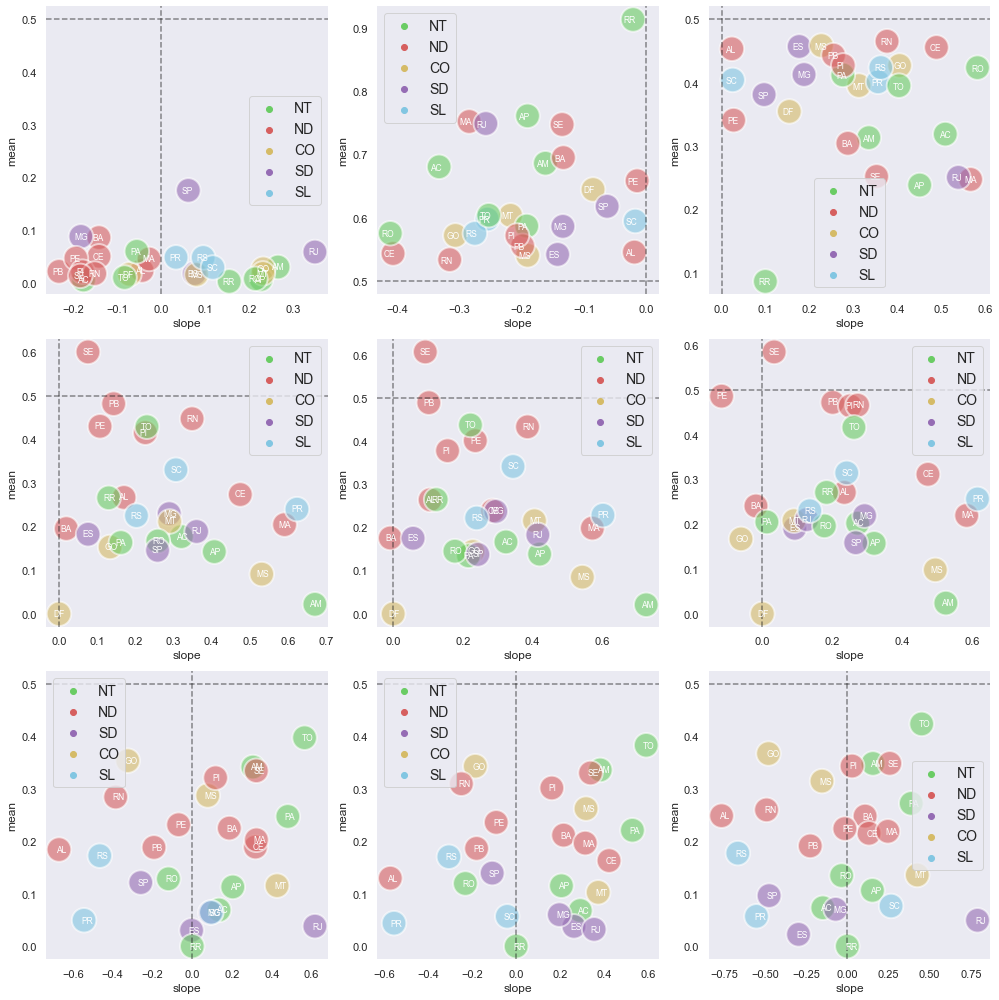

In [3]:
data = data_load.load_files_to_dict(
  data_info.get_files_path(config.PATH_DATA+'/uf_ano'))
data_plot.plot_scatter_matrix(data_info.get_matrix_data(data))